In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas
import ast
import os
from PIL import Image
import time
import copy
import numpy_indexed as npi
import cv2

In [68]:
# Get parts list - use indices of each part as "label", for one-hot encoding
parts_list = []
with open('./project_data/BerendPartsList') as f:
  for line in f:
    word = line[:len(line) - 1] # get rid of '\n
    parts_list.append(int(word))


In [69]:
csv_path = './project_data/Berend/CSV/labels.csv'
image_path = './project_data/Berend/Images'
bbox_label_root = './project_data/finalOutput'
data = pandas.read_csv(csv_path)
# Convert label col to list of ints of part numbers:
for i in range(len(data["Labels"])):
  label = data["Labels"][i]
  list_row = ast.literal_eval(label)
  data["Labels"][i] = list(map(int, list_row))
# Do same for Color column:
for i in range(len(data["Color"])):
  label = data["Color"][i]
  list_row = ast.literal_eval(label)
  data["Color"][i] = list(map(int, list_row))

In [70]:
class BerendDataset(Dataset):
  # For our dataset, let us accept a CSV file as input
  # + a list of parts, for a one-hot encoding.
  # We will also accept a root directory for images. 
  # We also accept transformations to the image
  def __init__(self, csv_path, parts_list, image_root, transforms, bbox_root):
    self.csv_path = csv_path
    self.parts_list = parts_list
    self.image_root = image_root
    data = pandas.read_csv(csv_path)
    # Convert label col to list of ints of part numbers:
    for i in range(len(data["Labels"])):
      label = data["Labels"][i]
      list_row = ast.literal_eval(label)
      int_list = list(map(int, list_row))
      data["Labels"][i] = list(map(lambda x: parts_list.index(x), int_list))

    # Do same for Color column:
    for i in range(len(data["Color"])):
      label = data["Color"][i]
      list_row = ast.literal_eval(label)
      data["Color"][i] = torch.LongTensor(list(map(int, list_row)))
    
    self.data = data
    self.transforms = transforms
    self.bbox_root = bbox_root
    self.bbox_tracked = {}
    self._BBOX_COL_NAMES = ["Labels", "x_min", "y_min", "x_max", "y_max"]

  def __getitem__(self, idx):
    target = {}
    labels = self.data["Labels"][idx]

    filename = self.data["Name"][idx]
    #print(filename)
    img_path = os.path.join(self.image_root, filename + '.jpg')
    bbox_path = os.path.join(self.bbox_root, filename + '.csv')

    img = Image.open(img_path).convert("RGB")
    if self.transforms is not None:
      img = self.transforms(img)

    target["labels"] = torch.LongTensor(labels)

    if filename in self.bbox_tracked:
      bboxes = self.bbox_tracked[filename]
    else:
      bbox_data = pandas.read_csv(os.path.join(self.bbox_root, filename + '.csv'),
                                  skiprows=2,
                                  header=None,
                                  names=self._BBOX_COL_NAMES)
      bbox_data_np = bbox_data.to_numpy(dtype=np.int_)
      bbox_labels = bbox_data_np[:, 0]
      bbox_targets = bbox_data_np[:, 1:]
      temp = []
      scalex = 330/3072
      scaley = 550/4608
      for b in bbox_targets:
        abox = []
        abox.append(b[0]*scalex)
        abox.append(b[1]*scaley)
        abox.append(b[2]*scalex)
        abox.append(b[3]*scaley)
        temp.append(abox)
      bbox_targets = temp
      bboxes = torch.zeros([len(labels), 4], dtype=torch.long)
      for i in range(len(bbox_labels)):
        bboxes[i, :] = torch.LongTensor(bbox_targets[i])
      self.bbox_tracked[filename] = bboxes

    target["boxes"] = bboxes
    
    return img, target
  def __len__(self):
        return len(self.data)

In [71]:
data_transform = transforms.Compose([transforms.Resize((375, 500)), transforms.ToTensor()])
dataset = BerendDataset(csv_path=csv_path, parts_list=parts_list, image_root=image_path, transforms=data_transform, bbox_root=bbox_label_root)

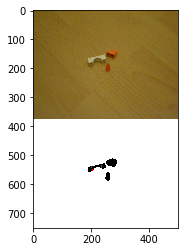

In [72]:
import cv2
low_H = 12
low_S = 0.55
low_V = 0.2
high_H = 205
high_S = 1
high_V = 1

item = dataset[680]
image, target = item
img = np.transpose(image, [1,2,0])

blurred = cv2.blur(np.float32(img), (3,3))
temp = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
masked = cv2.inRange(temp, (low_H, low_S, low_V), (high_H, high_S, high_V))
okay = cv2.dilate(masked, None, iterations=2)

params = cv2.SimpleBlobDetector_Params()
params.filterByArea = False
params.filterByInertia = False
params.filterByConvexity = False
detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(~okay)
im_with_keypoints = cv2.drawKeypoints(masked, keypoints, np.array([]),(255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im_v = np.concatenate((img, im_with_keypoints), axis=0)
plt.imshow(np.clip(im_v, 0, 1))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


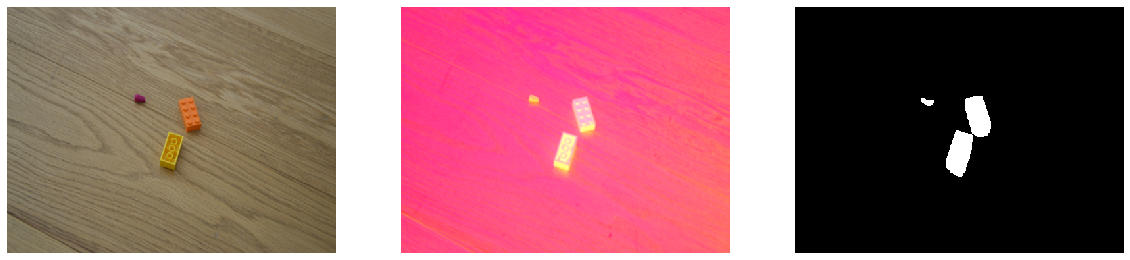

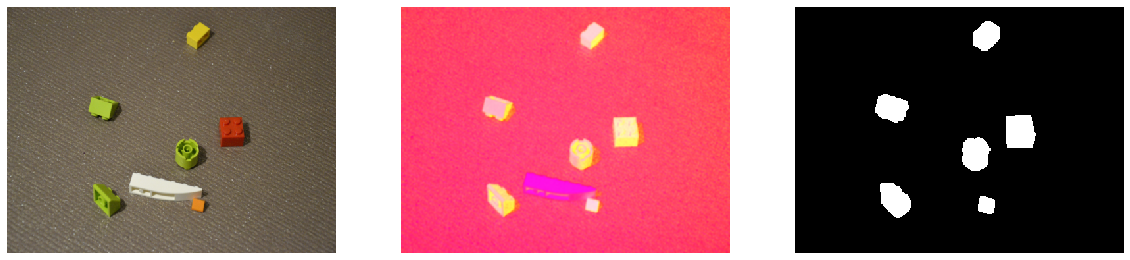

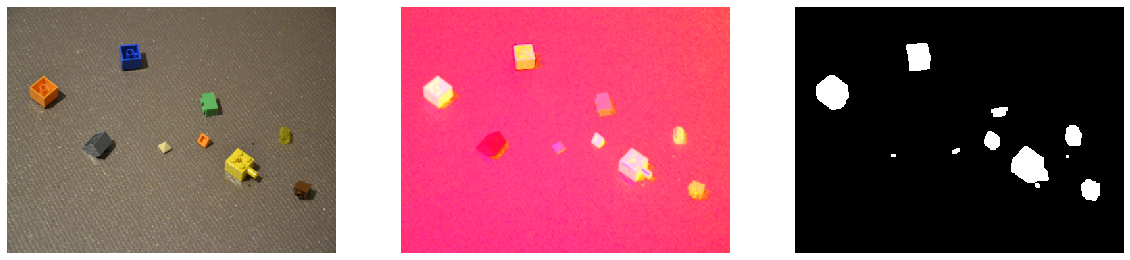

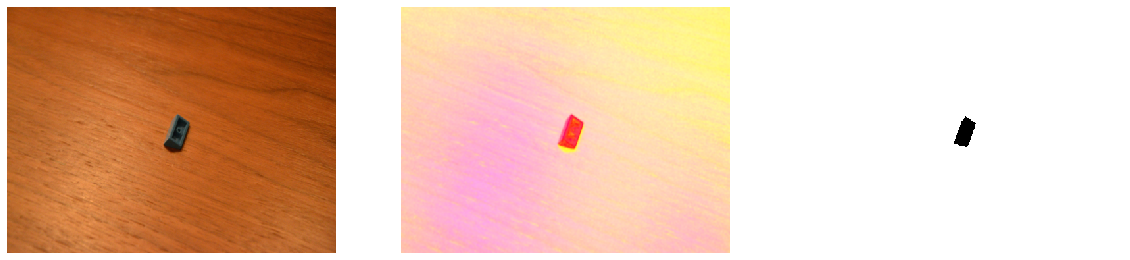

In [114]:
import cv2
low_H = 0
low_S = 0.55
low_V = 0
high_H = 255
high_S = 1
high_V = 1
k = 0
rand_ind = np.random.randint(0, len(dataset), 4)
for i in rand_ind:
    plt.figure(figsize=(20, 30))
    item = dataset[i]
    image, target = item
    img = np.transpose(image, [1,2,0])
    plt.subplot(5, 3, k+1)
    plt.axis('off')
    plt.imshow(img)
    k += 1
    blurred = cv2.blur(np.float32(img), (3,3))
    temp = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    plt.subplot(5, 3, k+1)
    plt.axis('off')
    plt.imshow(temp)
    k += 1
    masked = cv2.inRange(temp, (low_H, low_S, low_V), (high_H, high_S, high_V))
    okay = cv2.dilate(masked, None, iterations=2)
    plt.subplot(5, 3, k+1)
    plt.axis('off')
    plt.imshow(okay, cmap='gray')
    k += 1
    

In [115]:
import cv2
low_H = 0
low_S = 0.55
low_V = 0
high_H = 255
high_S = 255
high_V = 1
accuracy = 0
false_pos = 0
false_neg = 0
acc = []
fp = []
fn = []
k = 0
for i in range(len(dataset)):
    item = dataset[i]
    image, target = item
    img = np.transpose(image, [1,2,0])
    blurred = cv2.blur(np.float32(img), (3,3))
    temp = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    masked = cv2.inRange(temp, (low_H, low_S, low_V), (high_H, high_S, high_V))
    okay = cv2.dilate(masked, None, iterations=2)
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.filterByInertia = False
    params.filterByConvexity = False
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(~okay)
    output = cv2.drawKeypoints(masked, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    im_v = np.concatenate((img, output), axis=0)
    do = True
    if do:
        try:
            plt.imsave("./results2/"+ str(i) + ".png", np.clip(np.array(im_v), 0, 1))
        except ValueError as e:
            print(e)
    check = target["boxes"].tolist()
    count = 0
    num = 0
    for p in keypoints:
        num += 1
        for box in check:
            """print(p.pt[0]*scalex)
            print(p.pt[1]*scaley)
            print(box)
            print(p.pt[0]*scalex <= box[2])
            print(p.pt[0]*scalex >= box[0])
            print(p.pt[1]*scaley >= box[1])
            print(p.pt[1]*scaley <= box[3])"""
            if (p.pt[0] <= box[2] - 10) and (p.pt[0] >= box[0] + 10) and (p.pt[1] >= box[1] - 10) and (p.pt[1] <= box[3] + 10):
                check.remove(box)
                count += 1
    if count == num and len(check) == 0:
        accuracy += 1
        acc.append(i)
    if len(check) != 0:
        false_neg += 1
        fn.append(i)
    if count < num:
        false_pos += 1
        fp.append(i)

In [116]:
print("percentage of images with all legos identified correctly, and no false positives: ", accuracy/len(dataset))
print("percentage of images with missed lego detections: ", false_neg/len(dataset))
print("percentage of images with non-existent legos detected: ", false_pos/len(dataset))

percentage of images with all legos identified correctly, and no false positives:  0.049019607843137254
percentage of images with missed lego detections:  0.9252450980392157
percentage of images with non-existent legos detected:  0.6642156862745098


In [117]:
print(acc)
print(len(acc))

[0, 1, 2, 45, 46, 67, 68, 77, 83, 85, 86, 88, 96, 97, 100, 131, 133, 137, 138, 139, 168, 180, 181, 182, 246, 247, 394, 405, 444, 447, 464, 468, 471, 489, 511, 512, 513, 518, 655, 762]
40


In [118]:
print(fp)

[3, 4, 5, 6, 11, 14, 15, 17, 21, 23, 26, 27, 29, 35, 37, 39, 40, 41, 42, 47, 48, 49, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 75, 76, 78, 79, 80, 81, 82, 84, 87, 89, 90, 91, 98, 101, 104, 105, 106, 107, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 128, 132, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 170, 171, 172, 173, 176, 177, 179, 187, 188, 189, 190, 191, 192, 193, 194, 196, 197, 199, 200, 201, 202, 203, 206, 207, 208, 209, 210, 211, 215, 217, 218, 219, 220, 230, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 273, 276, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 307, 308, 309, 310, 311, 312, 313, 317, 319, 320, 326, 327, 329, 332, 333, 335, 336, 337, 338, 339, 340, 341, 342, 

In [119]:
print(fn)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 78, 79, 80, 81, 82, 87, 89, 90, 91, 92, 93, 94, 95, 98, 99, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 134, 135, 136, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 169, 170, 171, 172, 173, 174, 175, 177, 178, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 248, 249, 250, 251, 252, 253,